In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data
from torch.utils.data.sampler import SubsetRandomSampler

import os
import h5py
import matplotlib.pyplot as plt
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
from time import time

import FrEIA.framework  as Ff
import FrEIA.modules as Fm

import losses
import monitoring
from  utils import ScatteringProblemSplit
from visualizations import plot_outcomes_identified, describe_false_shapes, describe_positive_shapes


In [2]:
# this parameters work when I/100
filename_out    = 'output/inn.pt'
# Model to load and continue training. Ignored if empty string
filename_in     = ''
# Compute device to perform the training on, 'cuda' or 'cpu'
device          = 'cuda'
# Use interactive visualization of losses and other plots. Requires visdom
interactive_visualization = False # check first how this visdom works
# Run a list of python functions at test time after eacch epoch
# See toy_modes_train.py for reference example
test_time_functions = []

#######################
#  Training schedule  #
#######################

# Initial learning rate
lr_init         = 1e-3
#Batch size
batch_size      = 128
# Total number of epochs to train for
n_epochs        = 100

# End the epoch after this many iterations (or when the train loader is exhausted)
n_its_per_epoch = 200
# For the first n epochs, train with a much lower learning rate. This can be
# helpful if the model immediately explodes.
pre_low_lr      = 0
# Decay exponentially each epoch, to final_decay*lr_init at the last epoch.
final_decay     = 0.02
# L2 weight regularization of model parameters
l2_weight_reg   = 1e-5
# Parameters beta1, beta2 of the Adam optimizer
adam_betas = (0.9, 0.95)

#####################
#  Data dimensions  #
#####################
ndim_x_class     = 3
ndim_pad_x_class = 397
ndim_x_features     = 7
ndim_pad_x_features = 593

ndim_y     = 512
ndim_z     = 10
ndim_pad_zy = 478 


# Overwrite or import data loaders here.
# See dkfz_train.py for reference.
#from my_loaders import train_loader, test_loader

train_loader, test_loader = None, None

assert (ndim_x_class + ndim_x_features + ndim_pad_x_class+ ndim_pad_x_features 
        == ndim_y + ndim_z + ndim_pad_zy), "Dimensions don't match up"

############
#  Losses  #
############

train_forward_mmd    = True
train_backward_mmd   = True
train_reconstruction = True
train_max_likelihood = False


lambd_fit_forw         = 0.1
lambd_mmd_forw         = 50.
lambd_reconstruct      = 1.
lambd_mmd_back_class   = 10.
lambd_mmd_back_feature = 50.
lambd_max_likelihood   = 1.

# Both for fitting, and for the reconstruction, perturb y with Gaussian 
# noise of this sigma
add_y_noise     = 0 # think of smth smart here
# For reconstruction, perturb z 
add_z_noise     = 2e-2
# In all cases, perturb the zero padding
add_pad_noise   = 1e-2

# For noisy forward processes, the sigma on y (assumed equal in all dimensions).
# This is only used if mmd_back_weighted of train_max_likelihoiod are True.
y_uncertainty_sigma = 0.12 * 4

mmd_forw_kernels = [(0.2, 2), (1.5, 2), (3.0, 2)]
mmd_back_kernels = [(0.2, 0.1), (0.2, 0.5), (0.2, 2)]
mmd_back_weighted = True

###########
#  Model  #
###########

# Initialize the model parameters from a normal distribution with this sigma
init_scale = 0.10
#
N_blocks   = 5
#
exponent_clamping = 1.
#
hidden_layer_sizes = 32
#
use_permutation = True
#
verbose_construction = False

In [74]:
# this parameters work when I/100
filename_out    = 'output/inn_RNVP_split.pt'
# Model to load and continue training. Ignored if empty string
filename_in     = ''
# Compute device to perform the training on, 'cuda' or 'cpu'
device          = 'cuda'
# Use interactive visualization of losses and other plots. Requires visdom
interactive_visualization = False # check first how this visdom works
# Run a list of python functions at test time after eacch epoch
# See toy_modes_train.py for reference example
test_time_functions = []

#######################
#  Training schedule  #
#######################

# Initial learning rate
lr_init         = 1e-2
#Batch size
batch_size      = 128
# Total number of epochs to train for
n_epochs        = 30

# End the epoch after this many iterations (or when the train loader is exhausted)
n_its_per_epoch = 200
# For the first n epochs, train with a much lower learning rate. This can be
# helpful if the model immediately explodes.
pre_low_lr      = 0
# Decay exponentially each epoch, to final_decay*lr_init at the last epoch.
final_decay     = 0.02
# L2 weight regularization of model parameters
l2_weight_reg   = 1e-5
# Parameters beta1, beta2 of the Adam optimizer
adam_betas = (0.9, 0.95)

#####################
#  Data dimensions  #
#####################
ndim_x_class     = 3
ndim_pad_x_class = 200
ndim_x_features     = 7
ndim_pad_x_features = 412

ndim_y     = 512
ndim_z     = 10
ndim_pad_zy = 100 


# Overwrite or import data loaders here.
# See dkfz_train.py for reference.
#from my_loaders import train_loader, test_loader

train_loader, test_loader = None, None

assert (ndim_x_class + ndim_x_features + ndim_pad_x_class+ ndim_pad_x_features 
        == ndim_y + ndim_z + ndim_pad_zy), "Dimensions don't match up"

############
#  Losses  #
############

train_forward_mmd    = True
train_backward_mmd   = True
train_reconstruction = True
train_max_likelihood = False


lambd_fit_forw         = 10
lambd_mmd_forw         = 1
lambd_reconstruct      = 1.
lambd_mmd_back_class   = 100
lambd_mmd_back_feature = 100

# Both for fitting, and for the reconstruction, perturb y with Gaussian 
# noise of this sigma
add_y_noise     = 0 # think of smth smart here
# For reconstruction, perturb z 
add_z_noise     = 2e-2
# In all cases, perturb the zero padding
add_pad_noise   = 1e-2

# For noisy forward processes, the sigma on y (assumed equal in all dimensions).
# This is only used if mmd_back_weighted of train_max_likelihoiod are True.
y_uncertainty_sigma = 0.12 * 4

mmd_forw_kernels = [(0.2, 2), (1.5, 2), (3.0, 2)]
mmd_back_kernels = [(0.2, 0.1), (0.2, 0.5), (0.2, 2)]
mmd_back_weighted = True

###########
#  Model  #
###########

# Initialize the model parameters from a normal distribution with this sigma
init_scale = 0.10
#
N_blocks   = 5
#
exponent_clamping = 1.
#
hidden_layer_sizes = 32
#
use_permutation = True
#
verbose_construction = False

device = 'cuda'

In [3]:
learning_problem = ScatteringProblemSplit(device,  batch_size, ndim_x_class, ndim_x_features, ndim_y, ndim_z, ndim_pad_x_class, ndim_pad_x_features,
                       ndim_pad_zy, init_scale, final_decay, n_epochs, lr_init, adam_betas, l2_weight_reg, lambd_fit_forw, 
                       lambd_mmd_forw, lambd_mmd_back_class, lambd_mmd_back_feature, lambd_reconstruct, mmd_back_weighted, 
                       y_uncertainty_sigma, add_pad_noise, add_z_noise, add_y_noise, n_its_per_epoch, pre_low_lr, filename_out, mmd_forw_kernels, mmd_back_kernels)

In [4]:
learning_problem.read_data('/home/slaskina/simulations')
learning_problem.normalize_inputs()

In [75]:
learning_problem.update_hyperparameters(device,  batch_size, ndim_x_class, ndim_x_features, ndim_y, ndim_z, ndim_pad_x_class, ndim_pad_x_features,
                       ndim_pad_zy, init_scale, final_decay, n_epochs, lr_init, adam_betas, l2_weight_reg, lambd_fit_forw, 
                       lambd_mmd_forw, lambd_mmd_back_class, lambd_mmd_back_feature, lambd_reconstruct, mmd_back_weighted, 
                       y_uncertainty_sigma, add_pad_noise, add_z_noise, add_y_noise, n_its_per_epoch, pre_low_lr, filename_out, mmd_forw_kernels, mmd_back_kernels)

In [76]:
learning_problem.create_loaders()

In [77]:
def subnet2(dims_in, dims_out):
    return nn.Sequential(nn.Linear(dims_in, hidden_layer_sizes), nn.ReLU(),
                        nn.Linear(hidden_layer_sizes,  hidden_layer_sizes), nn.ReLU(),
                        nn.Linear(hidden_layer_sizes,  dims_out))


def subnet1(dims_in, dims_out):
    return nn.Sequential(nn.Linear(dims_in, hidden_layer_sizes*2), nn.ReLU(),
                        nn.Linear(hidden_layer_sizes*2,  hidden_layer_sizes), nn.ReLU(),
                        nn.Linear(hidden_layer_sizes,  dims_out))

input1 = Ff.InputNode(ndim_x_class + ndim_pad_x_class, name='input_class')
input2 = Ff.InputNode(ndim_x_features + ndim_pad_x_features, name='input_features')


nodes = [input1]
for i in range(N_blocks//2):
    nodes.append(Ff.Node(nodes[-1].out0, Fm.RNVPCouplingBlock, {'subnet_constructor':subnet1, 'clamp':exponent_clamping}, name = 'coupling_{}'.format(i)))

nodes.append(input2)
nodes.append( Ff.Node([nodes[-2].out0, nodes[-1].out0], Fm.Concat, {}, name='Concat'))
for i in range(N_blocks):
    nodes.append(Ff.Node(nodes[-1].out0, Fm.RNVPCouplingBlock, {'subnet_constructor':subnet2, 'clamp':exponent_clamping}, name = 'coupling_{}'.format(i)))
    if use_permutation:
        nodes.append(Ff.Node([nodes[-1].out0], Fm.PermuteRandom, {'seed':i}, name='permute_{}'.format(i)))

nodes.append(Ff.OutputNode([nodes[-1].out0], name='output'))
model = Ff.GraphINN(nodes, verbose=verbose_construction)


In [78]:
learning_problem.set_model(model)
learning_problem.set_optimizer()

In [79]:
learning_problem.train()

Epoch            L_fit       L_mmd_fwd      L_mmd_back       L_reconst     L_fit(test) L_mmd_fwd(test) L_mmd_back(test) L_reconst(test)
   000         10.5176         -0.6308          1.2276          0.6970          9.5970         -0.7260          1.2274          0.7687
   001          9.4436         -0.7257          1.2272          0.6801          9.6205         -0.7257          1.2268          0.7200
   002          9.5033         -0.7255          1.2274          0.6038          9.7145         -0.7254          1.2274          0.6452
   003          9.3179         -0.7258          1.2273          1.0699          9.1929         -0.7260          1.2272          1.4476
   004          8.9597         -0.7261          1.2265          1.4599          8.8223         -0.7262          1.2268          1.3977
   005          8.7444         -0.7259          1.2262          1.3685          8.5507         -0.7258          1.2263          1.2606
   006          8.6564         -0.7261          1.2251

In [80]:
df_train = learning_problem.create_table_from_outcomes(learning_problem.make_prediction(learning_problem.train_indices), learning_problem.train_indices)
df_val = learning_problem.create_table_from_outcomes(learning_problem.make_prediction(learning_problem.val_indices), learning_problem.val_indices) 
df_test = learning_problem.create_table_from_outcomes(learning_problem.make_prediction(learning_problem.test_indices), learning_problem.test_indices)

Accuracy is 35.95%
MSE for radius per shape for correctly identified instances as follows: sphere: 1069704640.0000, hardsphere: 19254354.0000 and cylinder: 1901037.7500
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: 91796.8906, hardsphere: 330.3344 and cylinder: 168565.8594
MSE for cylinder length for correctly identified instances: 3948233216.0000
MSE for cylinder length polydispersity for correctly identified instances: 33945.1523
MSE for cylinder length for correctly identified instances: 607.4470


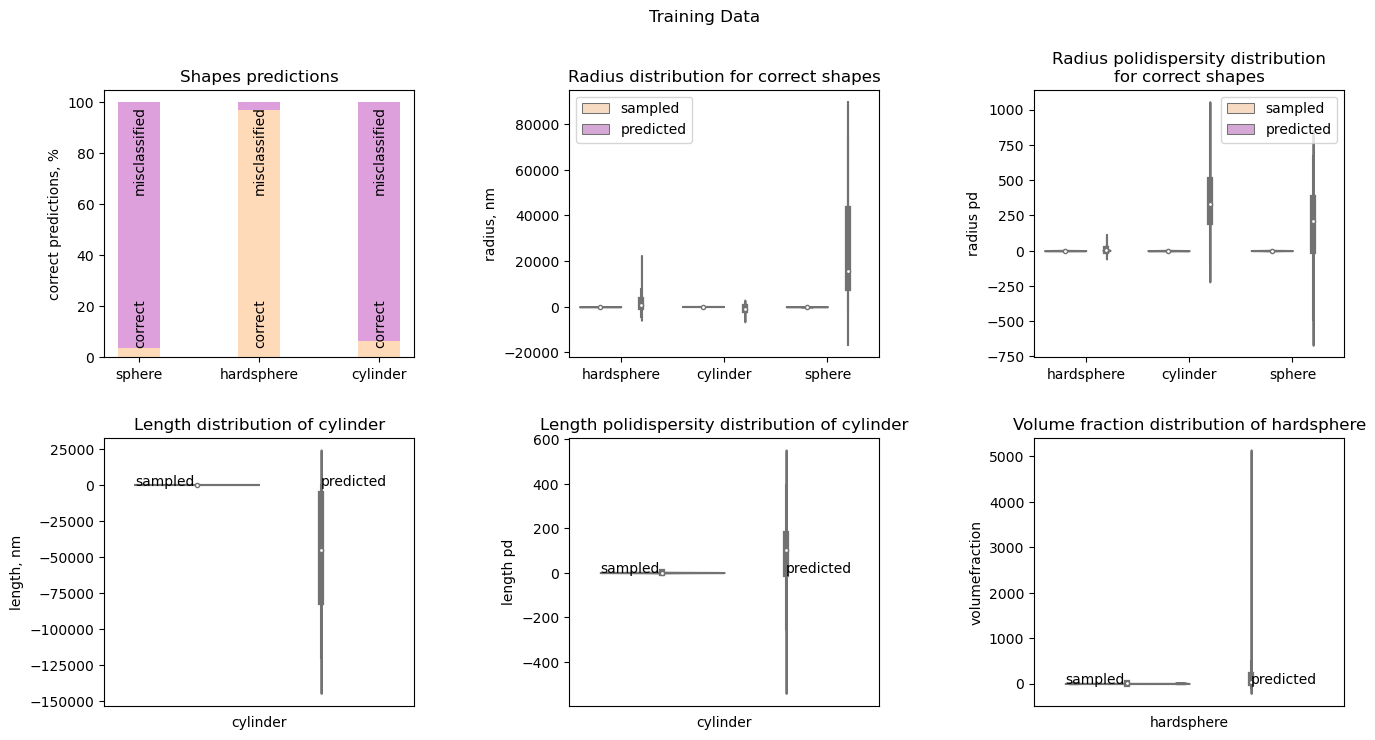

In [81]:
plot_outcomes_identified(df_train, 'Training')

Accuracy is 35.13%
MSE for radius per shape for correctly identified instances as follows: sphere: 1301471360.0000, hardsphere: 16304290.0000 and cylinder: 1922672.2500
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: 122760.2188, hardsphere: 349.2694 and cylinder: 160147.3281
MSE for cylinder length for correctly identified instances: 4031667968.0000
MSE for cylinder length polydispersity for correctly identified instances: 45186.0703
MSE for cylinder length for correctly identified instances: 1087.3583


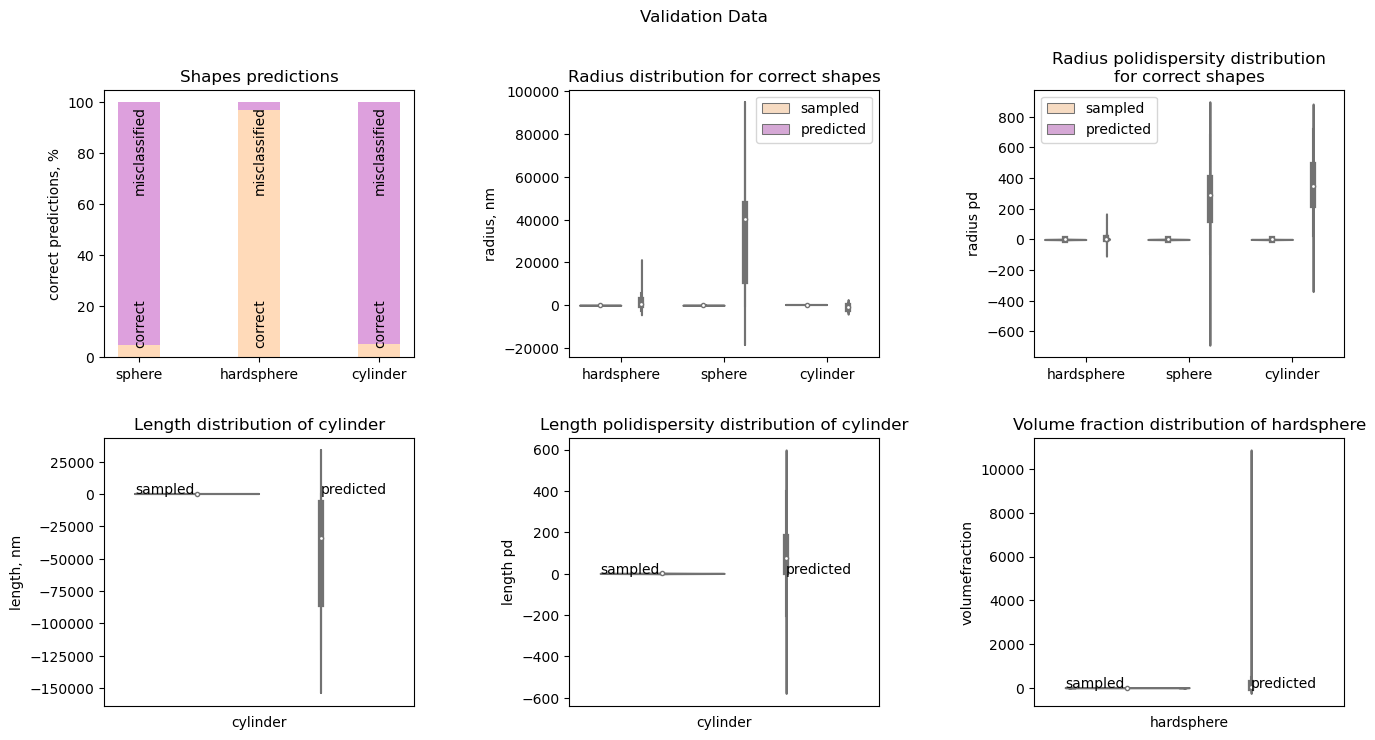

In [82]:
plot_outcomes_identified(df_val, 'Validation')

Accuracy is 34.87%
MSE for radius per shape for correctly identified instances as follows: sphere: 1082266880.0000, hardsphere: 20629546.0000 and cylinder: 2533342.7500
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: 117608.5547, hardsphere: 272.1408 and cylinder: 143031.7031
MSE for cylinder length for correctly identified instances: 3822454272.0000
MSE for cylinder length polydispersity for correctly identified instances: 52991.7383
MSE for cylinder length for correctly identified instances: 458.5356


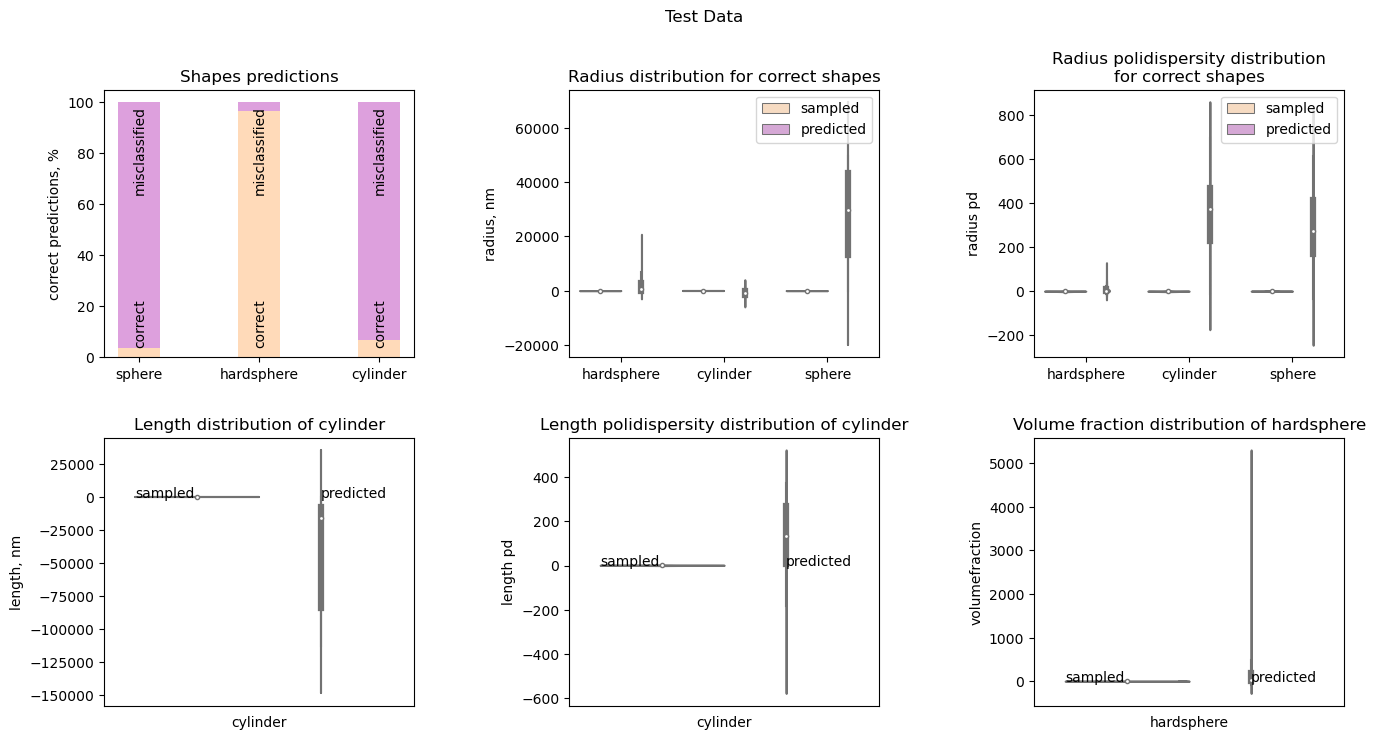

In [83]:
plot_outcomes_identified(df_test, 'Test')

In [53]:
df_test

,true_shape,pred_shape,radius,pred_radius,radius_pd,pred_radius_pd,length,pred_length,length_pd,pred_length_pd,volfraction,pred_volfraction
0,1,0,1.032652,-1.617661,1.265499,-0.027728,-0.618270,139.960800,-0.654812,0.473018,1.643524,0.020604
1,2,1,1.929026,-183.868988,0.332984,96.081886,0.469968,5656.720215,1.527977,531.354187,-0.547695,-2.254196
2,2,2,1.647959,508.135895,0.151548,61.891735,1.052781,690.341003,2.732629,372.398895,-0.547695,0.951568
3,2,1,2.503483,-958.956665,1.542599,78.124573,0.136401,3928.223389,0.901440,433.024933,-0.547695,-1.247265
4,1,2,1.342662,3.433823,1.321828,0.093449,-0.618270,-65.475792,-0.654812,1.085437,0.000110,-0.010999
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,1,1,-0.535699,3.603782,0.112266,-0.037133,-0.618270,-180.849762,-0.654812,0.078722,2.739133,-0.035494
1496,0,2,2.256697,-859.132019,-0.985058,27.023640,-0.618270,15682.449219,-0.654812,84.464661,-0.547695,-21.701046
1497,2,2,0.369333,166.994690,1.962551,4.952340,1.844693,8401.283203,1.004884,44.878815,-0.547695,-4.326635
1498,0,2,1.878434,-353.094086,-1.205321,17.669573,-0.618270,9118.571289,-0.654812,74.769669,-0.547695,-14.960136


In [35]:
inputs, labels = utils.read_data('/home/slaskina/simulations', ndim_x_class, ndim_x_features, ndim_y)

In [36]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(inputs[:,3:])
print(scaler.mean_)
inputs_new = scaler.transform(inputs[:,3:])
inputs_new = torch.concatenate((inputs[:,:3],torch.from_numpy(inputs_new) ), axis=1).type(torch.float32)

[1.70375634 1.68617923 1.70422724 0.1001788  8.56173952 0.04984434
 0.04999   ]


In [37]:
(train_indices, val_indices, test_indices), train_loader, test_loader = utils.create_loaders(inputs, labels, batch_size)

In [38]:

def subnet2(dims_in, dims_out):
    return nn.Sequential(nn.Linear(dims_in, hidden_layer_sizes), nn.ReLU(),
                        nn.Linear(hidden_layer_sizes,  hidden_layer_sizes), nn.ReLU(),
                        nn.Linear(hidden_layer_sizes,  dims_out))


def subnet1(dims_in, dims_out):
    return nn.Sequential(nn.Linear(dims_in, hidden_layer_sizes*2), nn.ReLU(),
                        nn.Linear(hidden_layer_sizes*2,  hidden_layer_sizes), nn.ReLU(),
                        nn.Linear(hidden_layer_sizes,  dims_out))

input1 = Ff.InputNode(ndim_x_class + ndim_pad_x_class, name='input_class')
input2 = Ff.InputNode(ndim_x_features + ndim_pad_x_features, name='input_features')


nodes = [input1]
for i in range(N_blocks//2):
    nodes.append(Ff.Node(nodes[-1].out0, Fm.RNVPCouplingBlock, {'subnet_constructor':subnet1, 'clamp':exponent_clamping}, name = 'coupling_{}'.format(i)))

nodes.append(input2)
nodes.append( Ff.Node([nodes[-2].out0, nodes[-1].out0], Fm.Concat, {}, name='Concat'))
for i in range(N_blocks):
    nodes.append(Ff.Node(nodes[-1].out0, Fm.RNVPCouplingBlock, {'subnet_constructor':subnet2, 'clamp':exponent_clamping}, name = 'coupling_{}'.format(i)))
    if use_permutation:
        nodes.append(Ff.Node([nodes[-1].out0], Fm.PermuteRandom, {'seed':i}, name='permute_{}'.format(i)))

nodes.append(Ff.OutputNode([nodes[-1].out0], name='output'))
model = Ff.GraphINN(nodes, verbose=verbose_construction)
      
model.to(device)


GraphINN(
  (module_list): ModuleList(
    (0): RNVPCouplingBlock(
      (subnet_s1): Sequential(
        (0): Linear(in_features=102, out_features=64, bias=True)
        (1): ReLU()
        (2): Linear(in_features=64, out_features=32, bias=True)
        (3): ReLU()
        (4): Linear(in_features=32, out_features=101, bias=True)
      )
      (subnet_t1): Sequential(
        (0): Linear(in_features=102, out_features=64, bias=True)
        (1): ReLU()
        (2): Linear(in_features=64, out_features=32, bias=True)
        (3): ReLU()
        (4): Linear(in_features=32, out_features=101, bias=True)
      )
      (subnet_s2): Sequential(
        (0): Linear(in_features=101, out_features=64, bias=True)
        (1): ReLU()
        (2): Linear(in_features=64, out_features=32, bias=True)
        (3): ReLU()
        (4): Linear(in_features=32, out_features=102, bias=True)
      )
      (subnet_t2): Sequential(
        (0): Linear(in_features=101, out_features=64, bias=True)
        (1): ReLU(

In [39]:

params_trainable = list(filter(lambda p: p.requires_grad, model.parameters()))
for p in params_trainable:
    p.data = init_scale * torch.randn(p.data.shape).to(device)

gamma = (final_decay)**(1./n_epochs)
optim = torch.optim.Adam(params_trainable, lr=lr_init, betas=adam_betas, eps=1e-6, weight_decay=l2_weight_reg)
weight_scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=1, gamma=gamma)

def optim_step():
    #for p in params_trainable:
        #print(torch.mean(torch.abs(p.grad.data)).item())
    optim.step()
    optim.zero_grad()

def scheduler_step():
    #weight_scheduler.step()
    pass

def save(name):
    torch.save({'opt':optim.state_dict(),
                'net':model.state_dict()}, name)

def load(name):
    state_dicts = torch.load(name)
    model.load_state_dict(state_dicts['net'])
    try:
        optim.load_state_dict(state_dicts['opt'])
    except ValueError:
        print('Cannot load optimizer for some reason or other')

In [40]:

def noise_batch(ndim):
    return torch.randn(batch_size, ndim).to(device)

def loss_max_likelihood(out, y, model):
    
    _, jac = model(y, rev = True, jac  = True) 
    neg_log_likeli = ( 0.5 / y_uncertainty_sigma**2 * torch.sum((out[:, -ndim_y:]       - y[:, -ndim_y:])**2, 1)
                     + 0.5 / 0.1**2   * torch.sum((out[:, ndim_z:-ndim_y] - y[:, ndim_z:-ndim_y])**2, 1)
                     + 0.5 * torch.sum(out[:, :ndim_z]**2, 1)
                     - jac)

    return lambd_max_likelihood * torch.mean(neg_log_likeli)

def loss_forward_mmd(out, y):
    # Shorten output, and remove gradients wrt y, for latent loss
    # [z,y] only
    output_block_grad = torch.cat((out[:, :ndim_z],
                                   out[:, -ndim_y:].data), dim=1) 
    y_short = torch.cat((y[:, :ndim_z], y[:, -ndim_y:]), dim=1)

    l_forw_fit = lambd_fit_forw * losses.l2_fit(out[:, ndim_z:], y[:, ndim_z:])
    l_forw_mmd = lambd_mmd_forw  * torch.mean(losses.forward_mmd(output_block_grad, y_short))

    return l_forw_fit, l_forw_mmd


def loss_backward_mmd(x_class, x_features, y):
    [x_samples_class, x_samples_features], x_samples_jac = model(y, rev=True, jac = True) 
    MMD_class = losses.backward_mmd(x_class, x_samples_class) 
    MMD_features = losses.backward_mmd(x_features, x_samples_features)
    if mmd_back_weighted:
        MMD_class *= torch.exp(- 0.5 / y_uncertainty_sigma**2 * losses.l2_dist_matrix(y, y))
        MMD_features *= torch.exp(- 0.5 / y_uncertainty_sigma**2 * losses.l2_dist_matrix(y, y))
    return lambd_mmd_back_class * torch.mean(MMD_class)+lambd_mmd_back_feature * torch.mean(MMD_features)


def loss_reconstruction(out_y, x_class, x_features):
    cat_inputs = [out_y[:, :ndim_z] + add_z_noise * noise_batch(ndim_z)] # list with 1 tensor
    
    if ndim_pad_zy:
        cat_inputs.append(out_y[:, ndim_z:-ndim_y] + add_pad_noise * noise_batch(ndim_pad_zy)) # list with 2 tensor
    cat_inputs.append(out_y[:, -ndim_y:] + add_y_noise * noise_batch(ndim_y)) # list with 3 tensors
    [x_reconstructed_class, x_reconstructed_features], x_reconstructed_jac = model(torch.cat(cat_inputs, 1), rev=True, jac = True) # concatenate list elements along axis 1
    return lambd_reconstruct * (losses.l2_fit(x_reconstructed_class[:, :ndim_pad_x_class], x_class[:,:ndim_pad_x_class]) + losses.l2_fit(x_reconstructed_features[:,:ndim_pad_x_features], x_features[:,:ndim_pad_x_features]) )# needs fix

def train_epoch(i_epoch, test=False):
    if not test:
        model.train()
        loader = train_loader

    if test:
        model.eval()
        loader = test_loader
        nograd = torch.no_grad()
        nograd.__enter__()


    batch_idx = 0
    loss_history = []

    for x, y in loader:

        if batch_idx > n_its_per_epoch:
            break
        batch_losses = []

        batch_idx += 1

        x, y = x.to(device), y.to(device)

        if add_y_noise > 0:
            y += add_y_noise * noise_batch(ndim_y)
        if ndim_pad_x_class:
            x_class = torch.cat((x[:,:3], add_pad_noise * noise_batch(ndim_pad_x_class)), dim=1)
        
        if ndim_pad_x_features:
            x_features = torch.cat((x[:,3:], add_pad_noise * noise_batch(ndim_pad_x_features)), dim=1)
        if ndim_pad_zy:
            y = torch.cat((add_pad_noise * noise_batch(ndim_pad_zy), y), dim=1)
        y = torch.cat((noise_batch(ndim_z), y), dim=1)

        out_y, out_y_jac = model([x_class,x_features], jac  = True)
        # tuple with output[0] and jacobian[1]
        if train_max_likelihood:
            batch_losses.append(loss_max_likelihood(out_y, y, model))

        if train_forward_mmd:
            batch_losses.extend(loss_forward_mmd(out_y, y))

        if train_backward_mmd:
            batch_losses.append(loss_backward_mmd(x_class,x_features, y))
            

        if train_reconstruction:
            batch_losses.append(loss_reconstruction(out_y.data, x_class, x_features))

        l_total = sum(batch_losses)
        loss_history.append([l.item() for l in batch_losses]) # lisr of lists: list for each batch

        if not test:
            l_total.backward()
            optim_step()

    if test:
        monitoring.show_hist(out_y[:, :ndim_z])
        monitoring.show_cov(out_y[:, :ndim_z])
        if test_time_functions:
            out_x_class, out_x_features, out_x_jac = model(y, rev=True, jac = True) 
            for f in test_time_functions:
                f(out_x_class, out_x_features, out_y, x_class,x_features, y)

        nograd.__exit__(None, None, None)
    return np.mean(loss_history, axis=0)

def train():
    monitoring.restart()

    try:
        monitoring.print_config()
        t_start = time()
        for i_epoch in range(-pre_low_lr, n_epochs):

            if i_epoch < 0:
                for param_group in optim.param_groups:
                    param_group['lr'] = lr_init * 1e-1

            train_losses = train_epoch(i_epoch) # mean over batches
            test_losses  = train_epoch(i_epoch, test=True)
            t = np.concatenate([train_losses, test_losses])
            monitoring.show_loss(t)
            scheduler_step() 

    except:
        save(filename_out + '_ABORT')
        raise

    finally:
        print("\n\nTraining took %f minutes\n\n" % ((time()-t_start)/60.))
        save(filename_out)



In [41]:
train()


Config options:

  N_blocks                 	5
  adam_betas               	(0.9, 0.95)
  add_pad_noise            	0.01
  add_y_noise              	0.05
  add_z_noise              	0.02
  batch_size               	256
  device                   	cuda
  exponent_clamping        	3.0
  filename_in              	
  filename_out             	output/my_inn.pt
  final_decay              	0.02
  hidden_layer_sizes       	16
  init_scale               	0.1
  interactive_visualization	False
  l2_weight_reg            	1e-05
  lambd_fit_forw           	10.0
  lambd_max_likelihood     	1.0
  lambd_mmd_back_class     	500.0
  lambd_mmd_back_feature   	50.0
  lambd_mmd_forw           	50.0
  lambd_reconstruct        	1.0
  lr_init                  	0.001
  mmd_back_kernels         	[(0.2, 0.1), (0.2, 0.5), (0.2, 2)]
  mmd_back_weighted        	True
  mmd_forw_kernels         	[(0.2, 2), (1.5, 2), (3.0, 2)]
  n_epochs                 	25
  n_its_per_epoch          	200
  ndim_pad_x_class         	39

In [42]:
from visualizations import plot_outcomes_identified, describe_false_shapes, describe_positive_shapes, create_table_from_outcome

In [43]:
def make_prediction(labels, model):
    y = torch.cat((add_pad_noise * torch.randn( len(labels), ndim_pad_zy).to('cuda'), labels.to('cuda')), dim=1)
    y = torch.cat((torch.randn( len(labels), ndim_z).to('cuda'), y), dim=1)
    [pred_class, pred_features], _ = model(y, rev = True)  # output of NN without padding
    return np.concatenate((pred_class.cpu().detach()[:,:ndim_x_class], pred_features.cpu().detach()[:, :ndim_x_features]), axis=1)


In [44]:
df_train = create_table_from_outcome(make_prediction(labels[train_indices], model), inputs_new[train_indices])
df_val = create_table_from_outcome(make_prediction(labels[val_indices],model), inputs_new[val_indices]) 
df_test = create_table_from_outcome(make_prediction(labels[test_indices], model), inputs_new[test_indices])

In [45]:
df_train.head()

,true_shape,pred_shape,radius,pred_radius,radius_pd,pred_radius_pd,length,pred_length,length_pd,pred_length_pd,volfraction,pred_volfraction
0,0,1,0.948295,4.470232e+09,-1.325040,1.377278e+09,-0.61827,1.240153e+10,-0.654812,5.162115e+09,-0.547695,-3.890051e+09
1,1,1,1.799317,9.046817e+08,1.290031,2.780411e+08,-0.61827,2.510858e+09,-0.654812,1.044823e+09,1.095719,-7.874148e+08
2,1,1,1.184450,2.523550e+08,-1.283191,7.819030e+07,-0.61827,7.031454e+08,-0.654812,2.925501e+08,1.095719,-2.199647e+08
3,1,1,0.540082,5.432257e+07,-0.797140,1.669253e+07,-0.61827,1.507661e+08,-0.654812,6.273216e+07,1.643524,-4.727775e+07
4,1,1,1.033210,2.328869e+04,-1.025985,5.951242e+03,-0.61827,6.863131e+04,-0.654812,2.590714e+04,-0.547695,-2.081442e+04


Accuracy is 33.08%
MSE for radius per shape for correctly identified instances as follows: sphere: 9917189120.0000, hardsphere: inf and cylinder: 39046525428650999808.0000
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: 510378.8125, hardsphere: inf and cylinder: 186719693438976.0000
MSE for cylinder length for correctly identified instances: 154361792021798060032.0000
MSE for cylinder length polydispersity for correctly identified instances: 31681139064176640.0000
MSE for cylinder length for correctly identified instances: inf


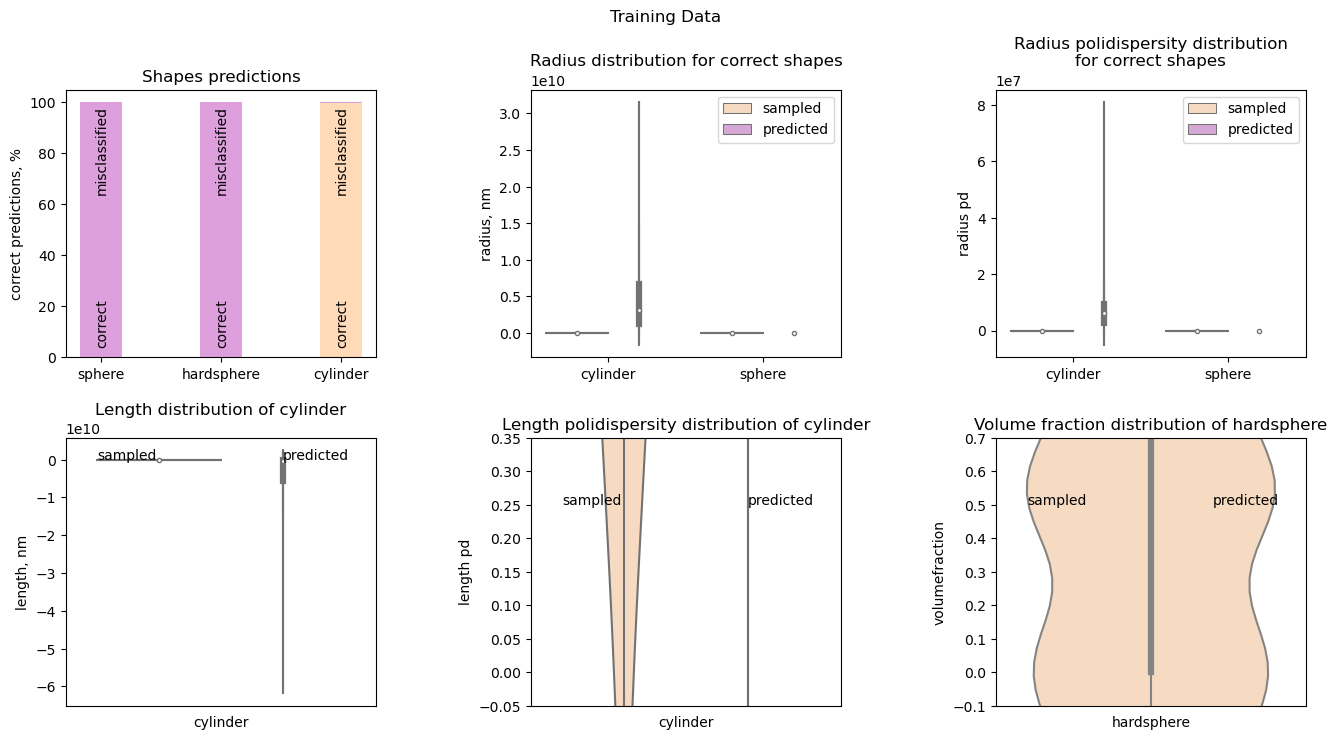

Accuracy is 33.37%
MSE for radius per shape for correctly identified instances as follows: sphere: inf, hardsphere: inf and cylinder: 38562986603034181632.0000
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: inf, hardsphere: inf and cylinder: 177988360470528.0000
MSE for cylinder length for correctly identified instances: 152342314617015369728.0000
MSE for cylinder length polydispersity for correctly identified instances: 30729760858439680.0000
MSE for cylinder length for correctly identified instances: inf


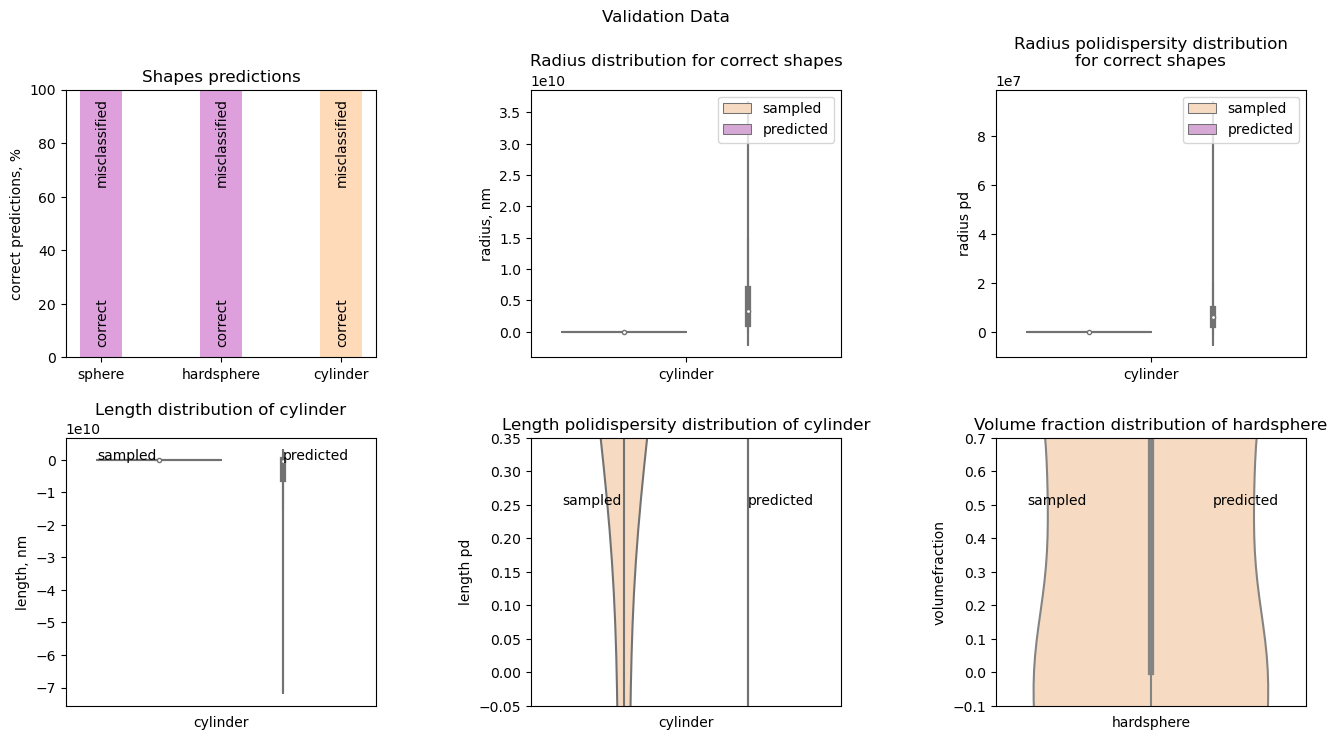

In [18]:
plot_outcomes_identified(df_val, 'Validation')

Accuracy is 34.53%
MSE for radius per shape for correctly identified instances as follows: sphere: inf, hardsphere: inf and cylinder: 36339059409113055232.0000
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: inf, hardsphere: inf and cylinder: 172076556091392.0000
MSE for cylinder length for correctly identified instances: 143731511294320181248.0000
MSE for cylinder length polydispersity for correctly identified instances: 29055554689171456.0000
MSE for cylinder length for correctly identified instances: inf


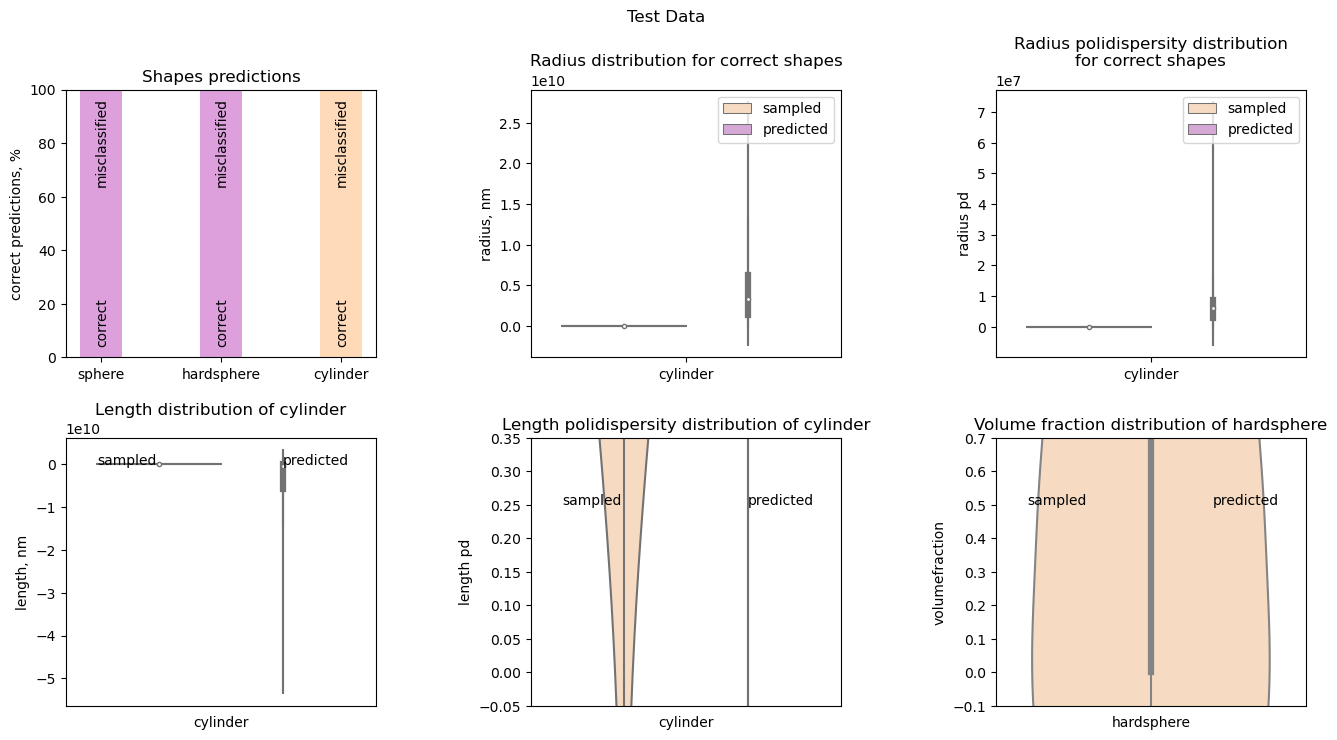

In [19]:
plot_outcomes_identified(df_test, 'Test')

In [37]:
df_test

,true_shape,pred_shape,radius,pred_radius,radius_pd,pred_radius_pd,length,pred_length,length_pd,pred_length_pd,volfraction,pred_volfraction
0,1,1,1.032652,-1.723486e+07,1.265499,-3.786954e+07,-0.618270,3.873092e+08,-0.654812,-6.125156e+06,1.643524,-3.073314e+07
1,2,1,1.929026,-3.123656e+09,0.332984,-7.326520e+09,0.469968,7.430464e+10,1.527977,-1.097126e+09,-0.547695,-5.572806e+09
2,2,1,1.647959,-3.660828e+09,0.151548,-8.586064e+09,1.052781,8.707971e+10,2.732629,-1.285833e+09,-0.547695,-6.530895e+09
3,2,1,2.503483,-3.280820e+09,1.542599,-7.694846e+09,0.136401,7.804093e+10,0.901440,-1.152353e+09,-0.547695,-5.852995e+09
4,1,1,1.342662,-6.753525e+07,1.321828,-7.545549e+07,-0.618270,4.820814e+08,-0.654812,-1.913075e+07,0.000110,-5.736679e+07
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,1,1,-0.535699,-5.070413e+02,0.112266,-5.951714e+02,-0.618270,3.638850e+03,-0.654812,-1.556929e+02,2.739133,-4.560361e+02
1496,0,1,2.256697,-2.756523e+09,-0.985058,-6.781564e+09,-0.618270,6.772145e+10,-0.654812,-1.042892e+09,-0.547695,-5.253415e+09
1497,2,1,0.369333,-9.959853e+08,1.962551,-2.448849e+09,1.844693,2.445688e+10,1.004884,-3.763832e+08,-0.547695,-1.897381e+09
1498,0,1,1.878434,-3.841283e+09,-1.205321,-4.291670e+09,-0.618270,2.741910e+10,-0.654812,-1.088083e+09,-0.547695,-3.262809e+09


In [38]:
from matplotlib import colors
print(colors.to_hex('peachpuff'),colors.to_hex('plum'))

#ffdab9 #dda0dd


In [39]:
false_shapes = df_test[df_test.true_shape != df_test.pred_shape]

FN_spheres = false_shapes[false_shapes.true_shape == 0]
FP_spheres = false_shapes[false_shapes.pred_shape == 0]
false_spheres = pd.concat([FN_spheres, FP_spheres])

FN_hardspheres = false_shapes[false_shapes.true_shape == 1]
FP_hardspheres = false_shapes[false_shapes.pred_shape == 1]
false_hardspheres = pd.concat([FN_hardspheres, FP_hardspheres])

FN_cylinders = false_shapes[false_shapes.true_shape == 2]
FP_cylinders = false_shapes[false_shapes.pred_shape == 2]
false_cylinders = pd.concat([FN_cylinders, FP_cylinders])

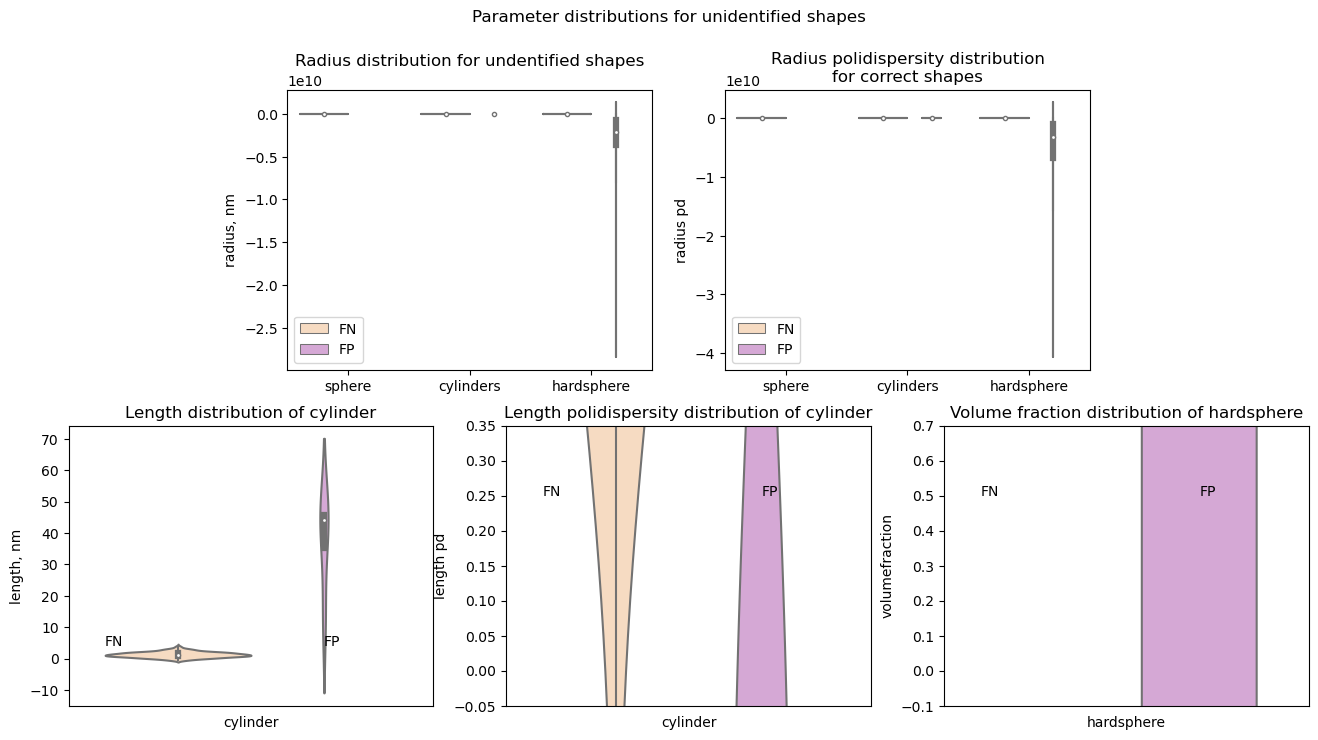

In [40]:
describe_false_shapes(false_spheres, false_hardspheres, false_cylinders)

ValueError: min() arg is an empty sequence

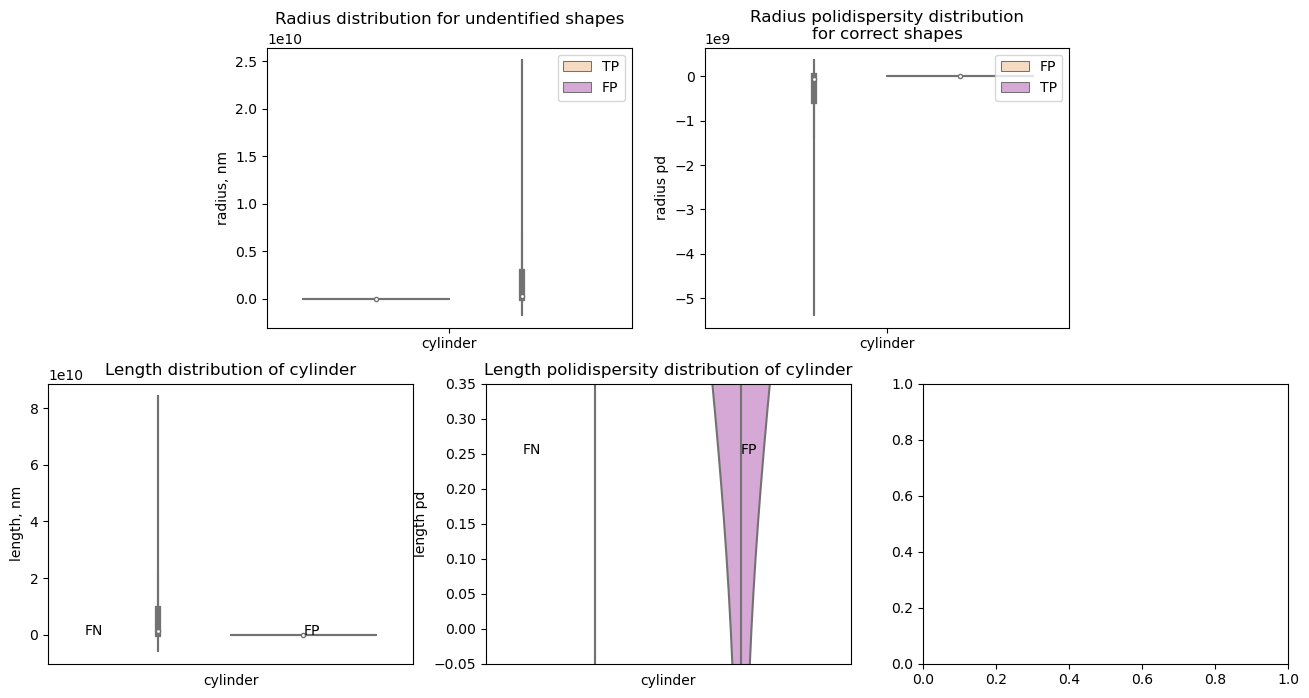

In [21]:
describe_positive_shapes(df_test)

## now look at the unidentified shapes more closely

In [145]:
def assign_class(row):
    if row[0]==1:
        return  'sphere'
    elif row[1] == 1:
        return 'hardsphere'
    elif row[2] == 1:
        return 'cylinder'
shapes_dict = {0:'sphere', 1:'hardsphere', 2:'cylinder'}

In [ ]:
prediction_class = pd.DataFrame(make_prediction(labels[test_indices], model)[:,0:3])
prediction_class['true_class'] = pd.DataFrame(inputs[test_indices][:,0:3]).apply(assign_class, axis=1)
prediction_class['prediction'] = prediction_class[[0,1,2]].idxmax(axis=1)
prediction_class.replace({'prediction':shapes_dict}, inplace = True)

In [ ]:
unidentified_shapes = prediction_class[prediction_class.true_class != prediction_class.prediction]

In [ ]:
# shardpheres id as cylinders <=0.2
temp = unidentified_shapes[(unidentified_shapes.true_class == 'hardsphere')& ((unidentified_shapes[(unidentified_shapes.true_class == 'hardsphere')][[0,1,2]].idxmax(axis=1)!=0) & (np.abs(unidentified_shapes[2] - unidentified_shapes[1])<=0.2))]
print(temp)
len(temp)

Empty DataFrame
Columns: [0, 1, 2, true_class, prediction]
Index: []


0

In [ ]:
# hardspheres id as spheres <=0.2
temp = unidentified_shapes[(unidentified_shapes.true_class == 'hardsphere')& ((unidentified_shapes[(unidentified_shapes.true_class == 'hardsphere')][[0,1,2]].idxmax(axis=1)!=2) & (np.abs(unidentified_shapes[0] - unidentified_shapes[1])<=0.2))]
print(temp)
len(temp)

Empty DataFrame
Columns: [0, 1, 2, true_class, prediction]
Index: []


0

In [ ]:
len(unidentified_shapes[(unidentified_shapes.true_class == 'hardsphere')]) # unid hs

486

In [ ]:
# spheres id as cylinders <=0.2
temp = unidentified_shapes[(unidentified_shapes.true_class == 'sphere')& ((unidentified_shapes[(unidentified_shapes.true_class == 'sphere')][[0,1,2]].idxmax(axis=1)!=1) & (np.abs(unidentified_shapes[2] - unidentified_shapes[0])<=0.2))]
print(temp)
len(temp)

             0         1         2 true_class prediction
124   0.280793  0.203505  0.330620     sphere   cylinder
347   0.436881  0.263383  0.611505     sphere   cylinder
438   0.486962  0.238967  0.515482     sphere   cylinder
595   0.472197 -0.080946  0.635986     sphere   cylinder
656   0.493128 -0.058647  0.569836     sphere   cylinder
977   0.485365  0.010025  0.562257     sphere   cylinder
1062  0.466171 -0.005881  0.604812     sphere   cylinder


7

In [ ]:
# spheres id as hs <=0.2
temp = unidentified_shapes[(unidentified_shapes.true_class == 'sphere')& ((unidentified_shapes[(unidentified_shapes.true_class == 'sphere')][[0,1,2]].idxmax(axis=1)!=2) & (np.abs(unidentified_shapes[1] - unidentified_shapes[0])<=0.2))]
print(temp)
len(temp)

             0         1         2 true_class  prediction
422   0.527154  0.721602 -0.067673     sphere  hardsphere
453   0.517304  0.555012 -0.066565     sphere  hardsphere
806   0.433207  0.512595 -0.088402     sphere  hardsphere
1408  0.444053  0.529602  0.010380     sphere  hardsphere
1460  0.348482  0.432917  0.178540     sphere  hardsphere


5

In [ ]:
len(unidentified_shapes[(unidentified_shapes.true_class == 'sphere')])

320

In [ ]:
# cylinders id as hardspheres <=0.2
temp=unidentified_shapes[(unidentified_shapes.true_class == 'cylinder')& ((unidentified_shapes[(unidentified_shapes.true_class == 'cylinder')][[0,1,2]].idxmax(axis=1)!=0) & (np.abs(unidentified_shapes[1] - unidentified_shapes[2])<=0.2))]
print(temp)
len(temp)

             0         1         2 true_class  prediction
535  -0.000465  0.621472  0.532205   cylinder  hardsphere
991  -0.125465  0.562154  0.513450   cylinder  hardsphere
1110 -0.017331  0.619450  0.571397   cylinder  hardsphere


3

In [ ]:
# cylinders id as spheres <=0.2
temp = unidentified_shapes[(unidentified_shapes.true_class == 'cylinder')& ((unidentified_shapes[(unidentified_shapes.true_class == 'cylinder')][[0,1,2]].idxmax(axis=1)!=1) & (unidentified_shapes[0] - unidentified_shapes[2]<=0.2))]
print(temp)
len(temp)

            0         1         2 true_class prediction
879  0.576867 -0.015559  0.564947   cylinder     sphere


1

In [ ]:
unidentified_shapes[(unidentified_shapes.true_class == 'cylinder')]

,0,1,2,true_class,prediction
0,0.022978,1.045312,0.010411,cylinder,hardsphere
1,0.162896,0.673255,-0.090661,cylinder,hardsphere
2,-0.008535,0.953166,-0.027160,cylinder,hardsphere
5,-0.007602,1.006908,0.011700,cylinder,hardsphere
7,-15.155534,1.454346,-0.024309,cylinder,hardsphere
...,...,...,...,...,...
1473,0.020576,1.003877,-0.009727,cylinder,hardsphere
1474,-0.019205,0.950437,-0.002928,cylinder,hardsphere
1486,-0.673747,1.984251,0.018414,cylinder,hardsphere
1493,0.005072,0.988568,-0.006903,cylinder,hardsphere


In [ ]:
#sphere_or_hardsphere
temp = prediction_class[(np.abs(prediction_class[0] - prediction_class[1])<0.4)& (prediction_class[[0,1,2]].idxmax(axis=1)!=2)]
temp.head()

,0,1,2,true_class,prediction
180,0.541568,0.483598,0.060665,sphere,sphere
256,0.366651,0.356288,0.048121,sphere,sphere
422,0.527154,0.721602,-0.067673,sphere,hardsphere
423,0.424439,0.798490,-0.075690,sphere,hardsphere
453,0.517304,0.555012,-0.066565,sphere,hardsphere


In [ ]:
len(temp[temp.true_class == temp.prediction])/len(temp)

0.5238095238095238

In [ ]:
import seaborn as sns

/home/slaskina/.conda/envs/ma/lib/python3.9/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


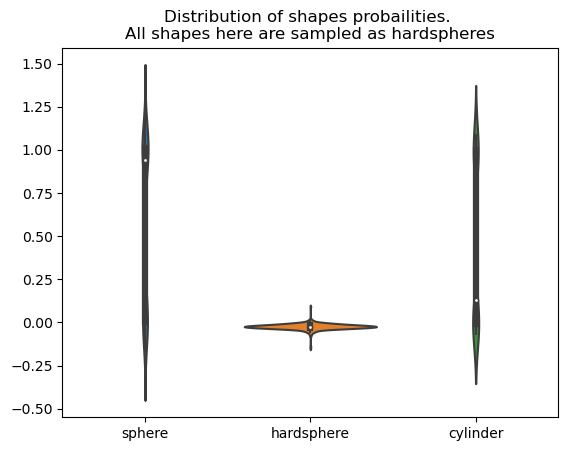

In [ ]:
sns.violinplot(unidentified_shapes[unidentified_shapes.true_class == 'hardsphere'][[0,1,2]]);
plt.title('Distribution of shapes probailities. \nAll shapes here are sampled as hardspheres')
plt.xticks([0,1,2], list(shapes_dict.values()));

/home/slaskina/.conda/envs/ma/lib/python3.9/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


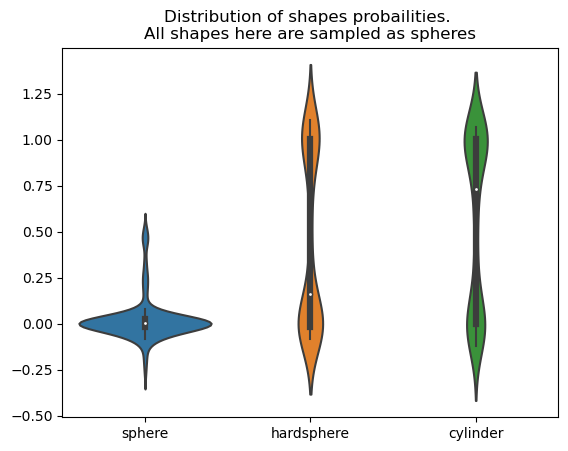

In [ ]:
sns.violinplot(unidentified_shapes[unidentified_shapes.true_class == 'sphere'][[0,1,2]]);
plt.title('Distribution of shapes probailities. \nAll shapes here are sampled as spheres')
plt.xticks([0,1,2], list(shapes_dict.values()));

/home/slaskina/.conda/envs/ma/lib/python3.9/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


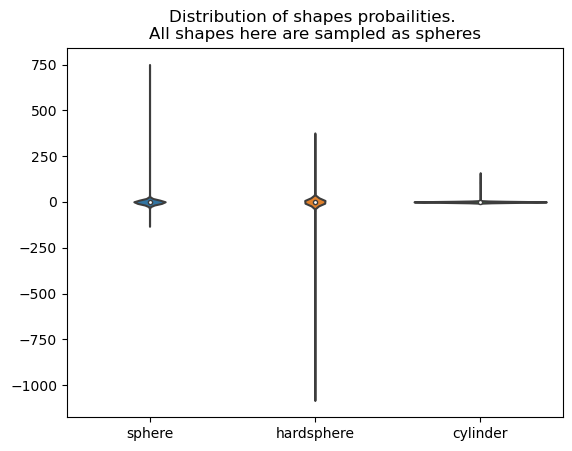

In [ ]:
sns.violinplot(unidentified_shapes[unidentified_shapes.true_class == 'cylinder'][[0,1,2]]);
plt.title('Distribution of shapes probailities. \nAll shapes here are sampled as spheres')
plt.xticks([0,1,2], list(shapes_dict.values()));

In [ ]:
unidentified_shapes

,0,1,2,true_class,prediction
0,0.022978,1.045312,0.010411,cylinder,hardsphere
1,0.162896,0.673255,-0.090661,cylinder,hardsphere
2,-0.008535,0.953166,-0.027160,cylinder,hardsphere
3,0.030299,-0.019449,0.990024,hardsphere,cylinder
4,-0.064076,0.960261,0.048948,sphere,hardsphere
...,...,...,...,...,...
1495,0.009665,-0.033105,1.012604,hardsphere,cylinder
1496,-0.009766,1.107931,-0.039471,sphere,hardsphere
1497,0.033013,1.032014,0.066133,cylinder,hardsphere
1498,-0.032073,1.026627,-0.009060,sphere,hardsphere
